# An attempt to tell from three sets of Spiderman suits from the TH trilogy

## 0. Dependency Set-up

In [1]:
!pip install -Uqq fastbook

In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

## 1.Data collecting

In [4]:
## Set key
import os
key = os.environ.get('AZURE_SEARCH_KEY','000c07452197485cab3ff72287547cc3')

In [5]:
## Check function
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [6]:
## Get search results using bing image search
results = search_images_bing(key,'spiderman')
ims = results.attrgot('contentUrl')
len(ims)

150

In [7]:
## Download results into 'dest'
dest = 'image/spider.jpg'
download_url(ims[0],dest)

Path('image/spider.jpg')

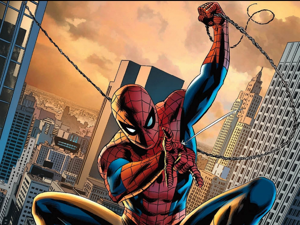

In [8]:
## Preview using 'Image' Object
im = Image.open(dest)
im.to_thumb(300)

## *Looks Solid!*

## Now, download suits data into three separate folders.

In [10]:
## specify movie types & path
spider_movies='home-coming','far from home','no way home black' ### here, since no way home have two sets of suits, we specify it to be the black(iron suit) one 
path = Path('spiderboys')

In [11]:
## create folders and collect data
if not path.exists():
    path.mkdir()
    for o in spider_movies:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key,f'spiderman {o} suit')
        download_images(dest,urls=results.attrgot('contentUrl'))
        

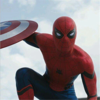

In [12]:
## check one pic for validity
dest = "spiderman/homecoming/00000004.jpg"
im = Image.open(dest)
im.to_thumb(100)

In [13]:
## check image path
fns = get_image_files(path)
fns

(#428) [Path('spiderboys/home-coming/00000047.jpg'),Path('spiderboys/home-coming/00000055.jpg'),Path('spiderboys/home-coming/00000107.jpg'),Path('spiderboys/home-coming/00000097.jpg'),Path('spiderboys/home-coming/00000148.jpg'),Path('spiderboys/home-coming/00000029.jpg'),Path('spiderboys/home-coming/00000112.jpg'),Path('spiderboys/home-coming/00000091.jpg'),Path('spiderboys/home-coming/00000093.jpg'),Path('spiderboys/home-coming/00000090.jpg')...]

In [14]:
## clean up failed downloads
failed = verify_images(fns)
failed

(#1) [Path('spiderboys/home-coming/00000130.jpg')]

In [15]:
## unlink(delete)
failed.map(Path.unlink)

(#1) [None]

# 2. Data Pre-possessing

In [16]:
# Step1: Load the data using DataBlock

## set-up DataBlock
spiders = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)
dls = spiders.dataloaders(path) 

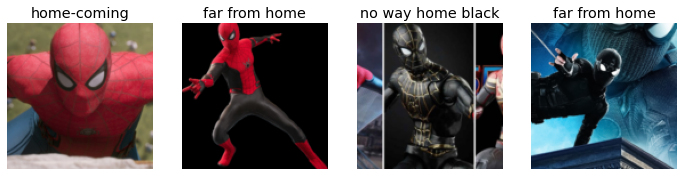

In [17]:
dls.valid.show_batch(max_n=4,nrows=1)

# *Data Augmentation

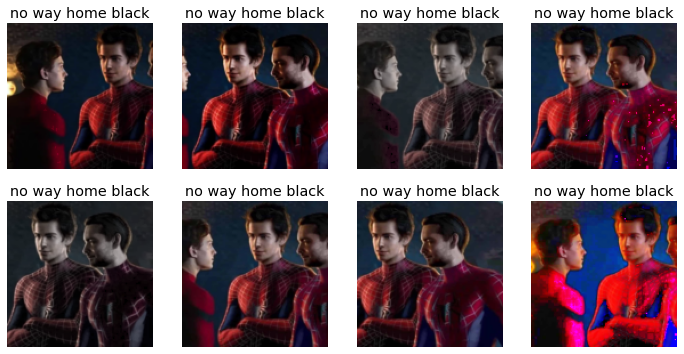

In [18]:
## data augmentation in terms of brightness, contrast as well as saturation etc.
spiders = spiders.new(item_tfms=Resize(128), batch_tfms = [Brightness(max_lighting = 0.3, p = 0.4),
    Contrast(max_lighting = 0.6, p = 0.4),
    Saturation(max_lighting = 0.75, p = 0.4)])

dls = spiders.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# 3. Train the model

In [19]:
# Step2&3: Build and Fit the Model
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.811585,1.334747,0.423529,00:09


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.336440,1.070117,0.352941,00:09
1,1.166926,0.977172,0.341176,00:11
2,1.017305,0.912380,0.282353,00:11
3,0.888121,0.904655,0.270588,00:09


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


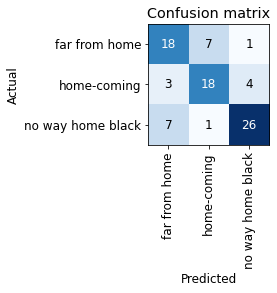

In [20]:
## check errors (interpretation) with confusion-matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

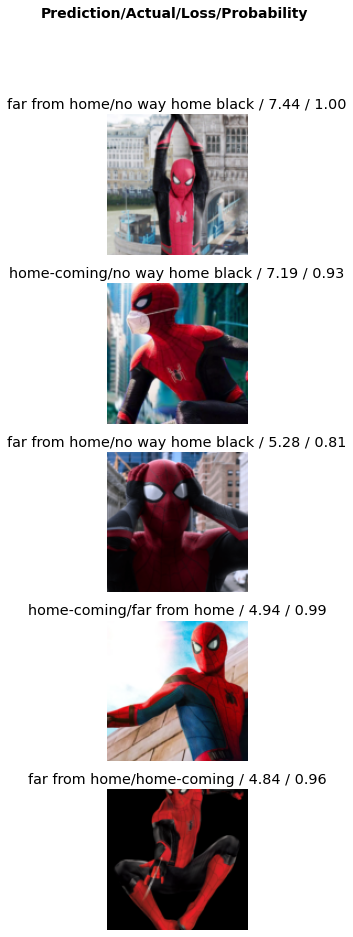

In [21]:
## plot out top-5 errors
interp.plot_top_losses(5, nrows=5)

In [22]:
## delete/modify polluted data
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [23]:
## update1
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,spiders in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/spiders)

In [24]:
## update2
spiders = spiders.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = spiders.dataloaders(path)

Could not do one pass in your dataloader, there is something wrong in it


<blockquote>Always remember to delete data with confusion during cleaning stage</blockquote>

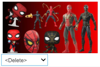

In [29]:
im = Image.open("del_eg.jpg")
im.to_thumb(100)

In [26]:
## run the model(step2&3) again/iteratively
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.797464,1.481797,0.506173,00:12


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.110714,0.932459,0.419753,00:12
1,0.990122,0.696526,0.395062,00:12
2,0.866277,0.640170,0.296296,00:12
3,0.753931,0.615786,0.259259,00:12
4,0.678546,0.614117,0.246914,00:12


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency e

# 4. Prediction

In [27]:
##upload using widget
btn_upload=widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [30]:
img = PILImage.create(btn_upload.data[-1])

In [31]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [32]:
## extracting predictions
pred,pred_idx,probs = learn.predict(img)

In [33]:
## Preidct!
### using predict_lbl
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred};Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: home-coming;Probability: 0.9980')

## As shown above, we managed to predict a spiderman suit correctly with confidence of over 99%. Yay!

# Further implementation Decorate with simple UI

In [ ]:
## VBOX